In [1]:
import numpy as np
import pandas as pd
import torch

from scipy.spatial.distance import cdist

from dist_ae import SetAutoencoderGNN, train_dist_ae
from plot_utils import plot_latent_pairs_overlaid

from distns import distns

distn_name = 'poisson'
generate_params = distns[distn_name]['generate_params']
sample_distn = distns[distn_name]['sample']
fr_dist = distns[distn_name]['fr_dist']


In [2]:
# generate multivariate normal data
n_sets = 1000
set_size = 100
n_features = 5

params_train = generate_params(n_sets, n_features)
params_test = generate_params(n_sets, n_features)

x_train = sample_distn(*params_train, n_sets, set_size, n_features)
x_test = sample_distn(*params_test, n_sets, set_size, n_features)


In [9]:
dist_ae = SetAutoencoderGNN(n_features, 16, 64, set_size)
optimizer = torch.optim.Adam(dist_ae.parameters(), lr=5e-4)

# create dataloader
train_loader = torch.utils.data.DataLoader(torch.from_numpy(x_train).float(), batch_size=20, shuffle=True)

dist_ae = train_dist_ae(dist_ae, optimizer, train_loader, n_epochs = 300)

Epoch 0, Loss: 4000.923095703125
Epoch 10, Loss: 1339.20166015625
Epoch 20, Loss: 1417.391357421875
Epoch 30, Loss: 1019.4925537109375
Epoch 40, Loss: 959.921142578125
Epoch 50, Loss: 641.9879760742188
Epoch 60, Loss: 600.5340576171875
Epoch 70, Loss: 414.9984436035156
Epoch 80, Loss: 261.12908935546875
Epoch 90, Loss: 243.9799346923828
Epoch 100, Loss: 211.46548461914062
Epoch 110, Loss: 262.4491271972656
Epoch 120, Loss: 231.81468200683594
Epoch 130, Loss: 184.94859313964844
Epoch 140, Loss: 211.03610229492188
Epoch 150, Loss: 167.19488525390625
Epoch 160, Loss: 206.39300537109375
Epoch 170, Loss: 171.00343322753906
Epoch 180, Loss: 146.8509063720703
Epoch 190, Loss: 163.10935974121094
Epoch 200, Loss: 166.23558044433594
Epoch 210, Loss: 129.54002380371094
Epoch 220, Loss: 140.80186462402344
Epoch 230, Loss: 154.31068420410156
Epoch 240, Loss: 138.3509063720703
Epoch 250, Loss: 151.6863555908203
Epoch 260, Loss: 149.5337371826172
Epoch 270, Loss: 158.5059814453125
Epoch 280, Loss: 16

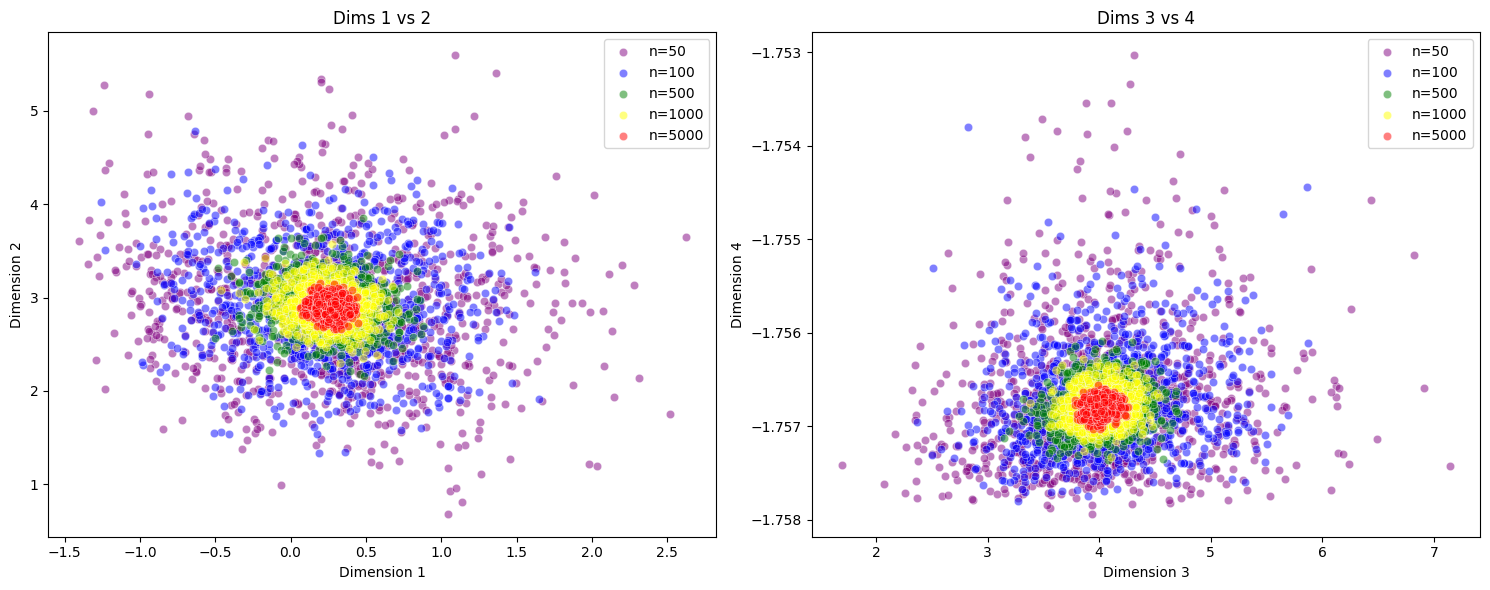

In [10]:
# Generate a single set of parameters
params = generate_params(1, n_features)

def sample_distn_fixed_params(n_sets, set_size):
    return sample_distn(*params, n_sets, set_size, n_features)

plot_latent_pairs_overlaid(dist_ae, sample_distn_fixed_params)

In [11]:
params = generate_params(500, n_features)
# sample 500 sets of 10,000 points from the distribution
x_samp = sample_distn(*params, 500, 10_000, n_features)
z_samp, _ = dist_ae(torch.from_numpy(x_samp).float())
z_samp = z_samp.detach().numpy()

# Compute pairwise cosine distances
lat_dists = cdist(z_samp, z_samp, metric='euclidean')


In [12]:
# compute distances between parameters
fr_dists = fr_dist(params)
l2_dists = np.linalg.norm(params[0][:, None, :] - params[0][None, :, :], axis=2)

In [13]:
dist_corr = np.corrcoef(np.vstack([l2_dists.flatten(), fr_dists.flatten(), lat_dists.flatten()]))
df = pd.DataFrame(dist_corr, index=['l2', 'fr', 'lat'], columns=['l2', 'fr', 'lat'])
print(df)

           l2        fr       lat
l2   1.000000  0.927389  0.903409
fr   0.927389  1.000000  0.876801
lat  0.903409  0.876801  1.000000
